In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.utils.vis_utils import plot_model
 
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#plt.imshow(Y_train[12000].reshape(28, 28))
#print(X_train[12000])

In [ ]:
train1 = pd.read_csv("/content/drive/MyDrive/Thesis/Dataset/malechar1.csv")
train1.tail

In [ ]:
train1 = pd.read_csv("/content/drive/MyDrive/Thesis/Dataset/malechar1.csv")
train2 = pd.read_csv("/content/drive/MyDrive/Thesis/Dataset/malechar2.csv")

frames = [train1, train2]

train = pd.concat(frames, ignore_index= True)

train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
0,1,1,1,1,1,0,1,0,1,1,4,2,1,5,0,2,4,4,4,4,4,1,0,1,1,1,4,4,0,0,1,2,8,7,5,0,1,2,0,0,...,1,1,0,0,0,6,0,138,255,193,0,0,0,0,2,0,1,3,0,1,2,1,2,3,0,1,0,0,0,0,0,0,1,5,1,65,253,123,0,10
1,2,1,36,14,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,7,230,162,14,3,1,0,0,0,0,0,...,2,0,0,141,255,45,18,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,6,2,152,245,20,0,3,0,0,0,10
2,0,0,0,0,0,1,0,1,0,0,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,42,111,0,3,...,0,0,2,2,1,24,253,153,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,4,0,0,6,1,1,1,4,0,145,59,0,2,0,10
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,6,3,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,...,2,0,0,0,0,0,0,0,0,0,0,1,2,0,53,174,186,204,181,180,69,0,3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,10
4,0,0,0,0,0,1,0,1,5,0,0,0,5,22,19,20,0,0,2,0,0,0,0,0,0,1,1,1,0,0,0,0,2,3,4,0,0,14,52,114,...,5,1,111,255,202,0,2,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,2,0,0,0,4,0,102,248,167,1,3,0,0,0,0,10


In [ ]:
train.tail()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
74658,2,2,0,0,0,4,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,3,0,95,134,25,0,2,0,0,0,0,0,...,244,255,255,255,255,255,255,193,102,31,0,0,0,0,0,0,0,0,0,0,0,0,5,5,7,4,0,34,88,120,188,202,207,198,133,38,0,0,7,59
74659,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,3,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,248,255,246,255,255,254,177,35,3,3,2,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,70,157,252,249,252,161,20,1,5,1,0,59
74660,0,0,0,1,2,0,2,2,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,2,2,3,0,2,3,25,43,...,2,3,2,1,1,0,0,1,0,0,0,3,1,0,6,5,0,3,34,59,182,186,193,134,7,0,0,3,0,1,0,1,1,0,0,0,0,0,0,59
74661,0,0,0,0,0,0,0,0,0,0,2,0,0,3,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,45,...,255,255,255,255,214,184,117,15,2,1,0,0,0,0,0,1,0,0,2,3,0,0,1,0,54,124,119,129,243,163,105,120,43,0,0,0,2,0,2,59
74662,0,0,0,0,0,0,2,2,0,1,3,2,0,0,0,1,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3,3,6,...,255,255,254,243,200,178,33,0,3,3,2,0,0,0,0,0,1,3,5,0,0,73,103,164,237,229,232,226,234,174,103,78,2,0,5,6,2,1,1,59


49


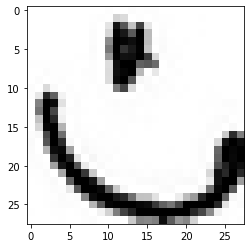

In [ ]:
train1 = pd.read_csv("/content/drive/MyDrive/Thesis/Dataset/malechar1.csv")
train2 = pd.read_csv("/content/drive/MyDrive/Thesis/Dataset/malechar2.csv")
 
frames = [train1, train2]
 
train = pd.concat(frames, ignore_index= True)
 
X_train = train["label"] - 10
Y_train = train.drop(labels = ["label"],axis = 1)
 
Y_train = Y_train / 255.0
 
Y_train = Y_train.values.reshape(-1,28,28,1)
 
plt.imshow(Y_train[74661].reshape(28, 28), cmap= 'gray_r')
print(X_train[74661])

In [ ]:
#plt.imshow(Y_train[38000].reshape(28, 28), cmap= 'gray_r')
#print(X_train[38000])

In [ ]:
def load_real_samples():
    train1 = pd.read_csv("/content/drive/MyDrive/Thesis/Dataset/malechar1.csv")
    train2 = pd.read_csv("/content/drive/MyDrive/Thesis/Dataset/malechar2.csv")

    frames = [train1, train2]

    train = pd.concat(frames, ignore_index= True)

    X_train = train["label"] - 10
    Y_train = train.drop(labels = ["label"],axis = 1)

    Y_train = Y_train / 255.0

    Y_train = Y_train.values.reshape(-1,28,28,1)

    return [Y_train, X_train]

In [ ]:
def define_discriminator(in_shape=(28,28,1), n_classes=50):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, np.prod(in_shape) )(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
def define_generator(latent_dim, n_classes=50):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, latent_dim)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

In [ ]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=50):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10000, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		if(i%10==0):
			zx= i+1;
			g_name= '/content/drive/MyDrive/Thesis/Our trained model/nEW/g_epoch '+ str(zx)+'.h5'
			g_model.save(g_name, include_optimizer=True)
			d_name= '/content/drive/MyDrive/Thesis/Our trained model/nEW/d_epoch '+ str(zx)+'.h5'
			d_model.save(d_name, include_optimizer=True)
			gan_name= '/content/drive/MyDrive/Thesis/Our trained model/nEW/gan_epoch '+ str(zx)+'.h5'
			gan_model.save(gan_name, include_optimizer=True)
   	# save the generator model
	g_model.save('/content/drive/MyDrive/Thesis/Our trained model/nEW/cgan_generator.h5', include_optimizer=True)
	d_model.save('/content/drive/MyDrive/Thesis/Our trained model/nEW/cgan_discriminator.h5', include_optimizer=True)
	gan_model.save('/content/drive/MyDrive/Thesis/Our trained model/nEW/cgan_gan.h5', include_optimizer=True,)

In [ ]:
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


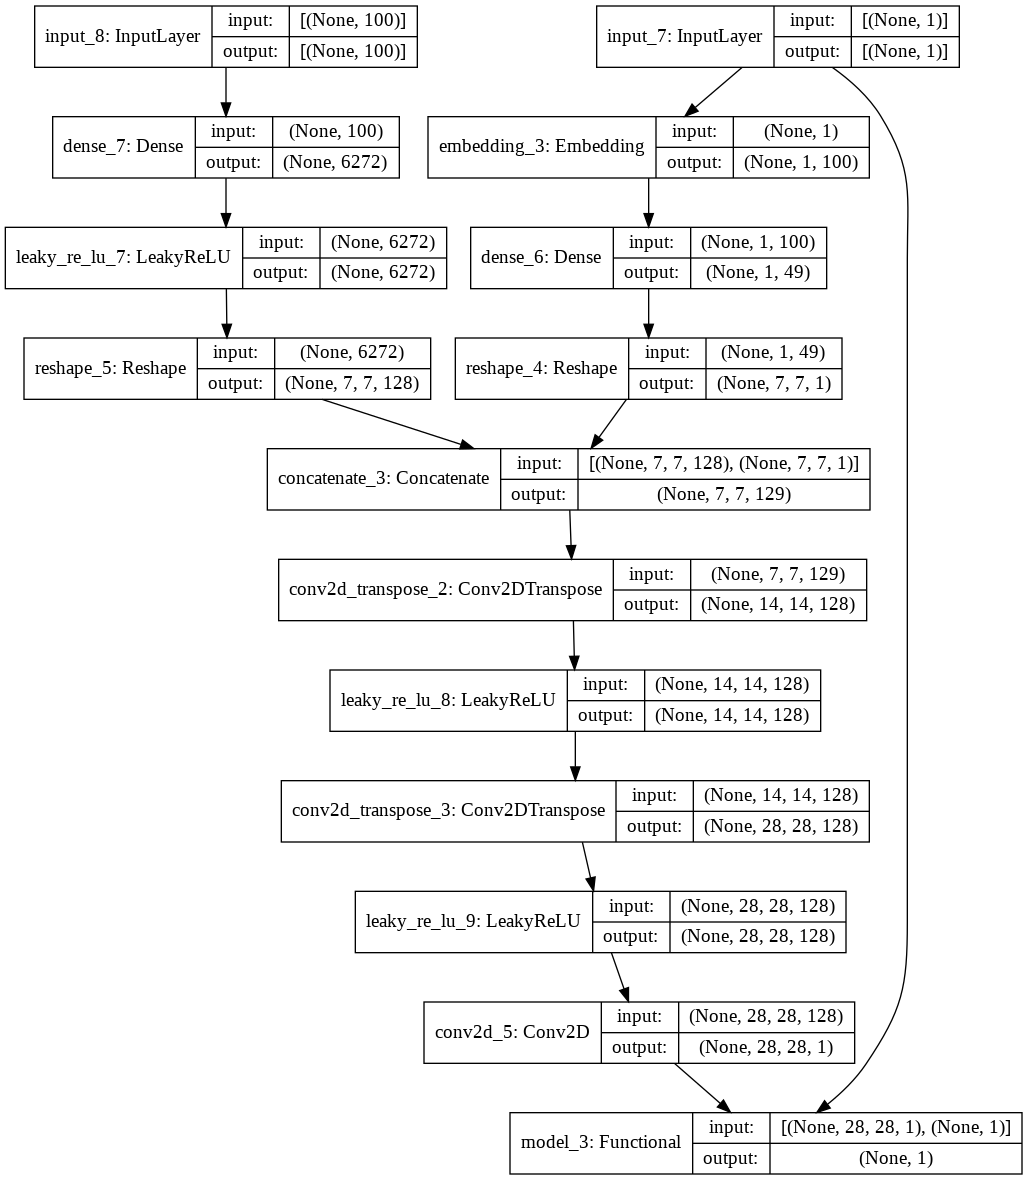

In [ ]:
plot_model(g_model, to_file='g_plot.png', show_shapes=True, show_layer_names=True)
plot_model(d_model, to_file='d_plot.png', show_shapes=True, show_layer_names=True)
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>206, 291/583, d1=0.183, d2=0.250 g=5.362
>206, 292/583, d1=0.063, d2=0.068 g=6.513
>206, 293/583, d1=0.156, d2=0.231 g=6.005
>206, 294/583, d1=0.173, d2=0.195 g=5.902
>206, 295/583, d1=0.092, d2=0.064 g=6.695
>206, 296/583, d1=0.253, d2=0.063 g=5.556
>206, 297/583, d1=0.068, d2=0.160 g=5.743
>206, 298/583, d1=0.158, d2=0.086 g=5.835
>206, 299/583, d1=0.067, d2=0.160 g=5.528
>206, 300/583, d1=0.211, d2=0.092 g=6.004
>206, 301/583, d1=0.104, d2=0.157 g=5.452
>206, 302/583, d1=0.152, d2=0.029 g=6.011
>206, 303/583, d1=0.130, d2=0.182 g=6.174
>206, 304/583, d1=0.057, d2=0.119 g=6.313
>206, 305/583, d1=0.243, d2=0.156 g=5.384
>206, 306/583, d1=0.164, d2=0.242 g=6.045
>206, 307/583, d1=0.109, d2=0.130 g=5.831
>206, 308/583, d1=0.088, d2=0.111 g=6.213
>206, 309/583, d1=0.153, d2=0.151 g=6.150
>206, 310/583, d1=0.384, d2=0.222 g=5.270
>206, 311/583, d1=0.083, d2=0.047 g=6.046
>206, 312/583, d1=0.037, d2=0.078 g=6.457
>206, 313/583, d1=0.107, 

In [ ]:
g_model = load_model('/content/drive/MyDrive/Thesis/Our trained model/Character/g_epoch 1067.h5')
d_model = load_model('/content/drive/MyDrive/Thesis/Our trained model/Character/d_epoch 1067.h5')
gan_model = load_model('/content/drive/MyDrive/Thesis/Our trained model/Character/gan_epoch 1067.h5')

In [ ]:
latent_dim = 100

# load image data
dataset = load_real_samples()

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>296, 434/583, d1=0.237, d2=0.069 g=0.000
>296, 435/583, d1=0.094, d2=0.181 g=0.000
>296, 436/583, d1=0.100, d2=0.136 g=0.000
>296, 437/583, d1=0.059, d2=0.079 g=0.000
>296, 438/583, d1=0.087, d2=0.096 g=0.000
>296, 439/583, d1=0.130, d2=0.065 g=0.000
>296, 440/583, d1=0.184, d2=0.094 g=0.000
>296, 441/583, d1=0.164, d2=0.086 g=0.000
>296, 442/583, d1=0.024, d2=0.056 g=0.000
>296, 443/583, d1=0.083, d2=0.096 g=0.000
>296, 444/583, d1=0.099, d2=0.080 g=0.000
>296, 445/583, d1=0.121, d2=0.087 g=0.000
>296, 446/583, d1=0.094, d2=0.095 g=0.000
>296, 447/583, d1=0.028, d2=0.062 g=0.000
>296, 448/583, d1=0.185, d2=0.040 g=0.000
>296, 449/583, d1=0.151, d2=0.115 g=0.000
>296, 450/583, d1=0.264, d2=0.121 g=0.000
>296, 451/583, d1=0.115, d2=0.087 g=0.000
>296, 452/583, d1=0.117, d2=0.115 g=0.000
>296, 453/583, d1=0.107, d2=0.099 g=0.000
>296, 454/583, d1=0.203, d2=0.160 g=0.000
>296, 455/583, d1=0.078, d2=0.161 g=0.000
>296, 456/583, d1=0.175, 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=25):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

In [ ]:
model = load_model('/content/drive/MyDrive/Thesis/Our trained model/Character/g_epoch 1368.h5')

In [ ]:
a = [0,1,2,3,4,5,6,7,8,9]
labels= np.asarray(a)

In [ ]:
latent_dim =100
n_samples = labels.size

x_input = randn(latent_dim * n_samples)

latent_points = x_input.reshape(n_samples, latent_dim)

In [ ]:
X  = model.predict([latent_points, labels])

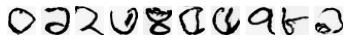

In [ ]:
for i in range(n_samples):
	pyplot.subplot(1,n_samples , i+1)
	pyplot.axis('off')
	pyplot.imshow(X[i].reshape(28,28), cmap='gray_r')

In [ ]:
for i in range(n_samples):
	pyplot.subplot(1,n_samples , i+1)
	pyplot.axis('off')
	pyplot.imshow(X[i].reshape(28,28))

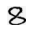

In [ ]:
n= 10
pyplot.subplot(n, n, 10)
		# turn off axis
pyplot.axis('off')
		# plot raw pixel data
pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
pyplot.show()

In [ ]:
a = [3, 9]
labels= np.asarray(a)
labels

In [ ]:
X  = model.predict([latent_points, labels])

In [ ]:
latent_points, labels = generate_latent_points(100, 100)
latent_points


In [ ]:
labels = asarray([x for _ in range(10) for x in range(10)])
labels

In [ ]:
X  = model.predict([latent_points, labels])

In [ ]:
X = (X + 1) / 2.0

In [ ]:
save_plot(X, 2)

# **Evaluation**

In [ ]:
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

In [ ]:
def load_real_samples():
    train1 = pd.read_csv("/content/drive/MyDrive/Thesis/Dataset/malechar1.csv")
    train2 = pd.read_csv("/content/drive/MyDrive/Thesis/Dataset/malechar2.csv")

    frames = [train1, train2]

    train = pd.concat(frames, ignore_index= True)

    X_train = train["label"] - 10
    Y_train = train.drop(labels = ["label"],axis = 1)

    Y_train = Y_train / 255.0

    Y_train = Y_train.values.reshape(-1,28,28,1)

    return [Y_train, X_train]

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=50):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

In [ ]:
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# load real images
images1, labels = load_real_samples()
shuffle(images1)
images1 = images1[:2000]
# load fake images
generator_model = load_model('/content/drive/MyDrive/Thesis/Our trained model/wgan/model_0030.h5')
[images2, labels], y = generate_fake_samples(generator_model,100,2000)
shuffle(images2)
print('Loaded', images1.shape, images2.shape)
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# calculate fid
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)    

Loaded (2000, 28, 28, 1) (2000, 28, 28, 1)
Scaled (2000, 299, 299, 3) (2000, 299, 299, 3)
FID: 71.746
